In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!source /content/drive/MyDrive/colab_env/bin/activate

# import exported file from other modules

In [44]:
import pickle
with open("/content/drive/MyDrive/WaterBalance_new/notebook/runoff_mahdoode_mashhad_4326_without_clip.pkl", "rb") as f:
    runoff_mashhad = pickle.load(f)

with open("/content/drive/MyDrive/WaterBalance_new/notebook/ET_hargreaves_mahdoode_mashhad_4326_pwp_and_fc.pkl", "rb") as f:
    ET_mashhad = pickle.load(f)

ET_mashhad

<xarray.Dataset>
Dimensions:          (x: 18, y: 13, time: 1)
Coordinates:
  * x                (x) float32 58.35 58.45 58.55 58.65 ... 59.85 59.95 60.05
  * y                (y) float32 37.05 36.95 36.85 36.75 ... 36.05 35.95 35.85
  * time             (time) datetime64[ns] 2022-01-31
    spatial_ref      int64 0
Data variables: (12/13)
    air_temperature  (time, y, x) float32 ...
    et_covered       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    e_noncovered     (time, y, x) float64 0.2922 0.3212 0.3705 ... 0.495 0.5007
    et_total         (time, y, x) float64 0.2922 0.3212 0.3705 ... 0.495 0.5007
    wp_10cm          (time, y, x) float64 17.53 15.74 15.1 ... 15.14 13.31 13.31
    fc_10cm          (time, y, x) float64 29.45 26.98 25.45 ... 23.47 23.47
    ...               ...
    fc_100cm         (time, y, x) float64 29.57 26.18 24.51 ... 23.57 23.57
    wp_200cm         (time, y, x) float64 17.5 15.09 14.46 ... 15.11 13.26 13.26
    fc_200cm         (time, y, x) float64 28.87 25.25 24.1 ... 25.65 22.82 22.82
    organic_10cm     (time, y, x) float64 0.017 0.017 0.009 ... 0.0 0.0 0.009
    organic_100cm    (time, y, x) float64 0.009 0.009 0.0 0.0 ... 0.0 0.0 0.0
    organic_200cm    (time, y, x) float64 0.0 0.009 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    history:          Created on 2022-02-06 07:16
    input_data_hash:  a1123a6e0d2788e1883ec8f01cc52110d92449cef4cf1591984fe91...

# import package

In [28]:
import os
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import geopandas as gpd
import ee
import wxee
import geemap
import rasterio
import rioxarray
import itertools

sys.path.append('/content/drive/MyDrive/WaterBalance_new/')

from qdwb.soil_content.soil_content import *
from qdwb.soil_content.constant import *

## Authorize in Google Earth Engine

In [29]:
service_account = 'test-175@ee-mohammadnejadmehdi77.iam.gserviceaccount.com'

credentials = ee.ServiceAccountCredentials(
    email=service_account, 
    key_file='/content/drive/MyDrive/private-key.json'
)

ee.Initialize(credentials)

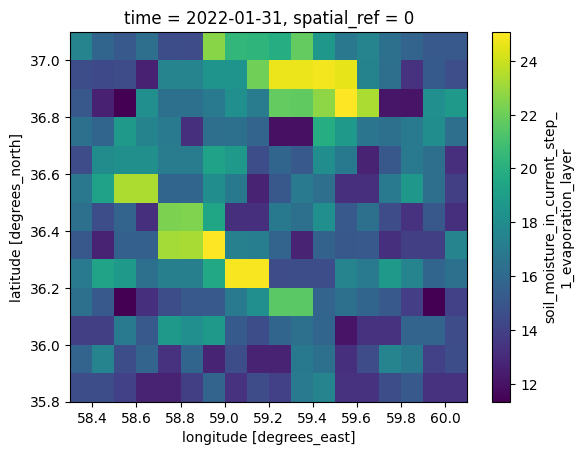

In [67]:
number_of_x = len(list(ET_mashhad.x.values.flatten()))
number_of_y = len(list(ET_mashhad.y.values.flatten()))

Ea_pyet = list(ET_mashhad.e_noncovered.values.flatten())
underground_runoff = list(runoff_mashhad.underground_runoff.values.flatten())
soil = list(runoff_mashhad.soilmoisture.values.flatten())
sub_soil = list(runoff_mashhad.sub_soilmoisture.values.flatten())
fc_list_10cm = list(ET_mashhad.fc_10cm.values.flatten())
wp_list_10cm = list(ET_mashhad.wp_10cm.values.flatten())


soil_moisture_in_current_step_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = fc,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = wp,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[0]
for i, j, z, fc, wp in zip(Ea_pyet, underground_runoff, soil, fc_list_10cm, wp_list_10cm)])

evaporation_adjusted_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = fc,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = wp,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[1]
for i, j, z, fc, wp in zip(Ea_pyet, underground_runoff, soil, fc_list_10cm, wp_list_10cm)])

infiltration_to_transpiration_layer_adjusted_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = fc,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = wp,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[2]
for i, j, z, fc, wp in zip(Ea_pyet, underground_runoff, soil, fc_list_10cm, wp_list_10cm)])

infiltration_to_transition_layer_adjusted_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = fc,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = wp,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[3]
for i, j, z, fc, wp in zip(Ea_pyet, underground_runoff, soil, fc_list_10cm, wp_list_10cm)])


soil_moisture_in_current_step_1 = soil_moisture_in_current_step_1.reshape(1,number_of_y,number_of_x)
evaporation_adjusted_1 = evaporation_adjusted_1.reshape(1,number_of_y,number_of_x)
infiltration_to_transpiration_layer_adjusted_1 = infiltration_to_transpiration_layer_adjusted_1.reshape(1,number_of_y,number_of_x)
infiltration_to_transition_layer_adjusted_1 = infiltration_to_transition_layer_adjusted_1.reshape(1,number_of_y,number_of_x)


ds_array_5 = runoff_mashhad.assign(soil_moisture_in_current_step_1_evaporation_layer=(['time', 'y', 'x'], soil_moisture_in_current_step_1))
ds_array_6 = ds_array_5.assign(evaporation_adjusted_1=(['time', 'y', 'x'], evaporation_adjusted_1))
ds_array_7 = ds_array_6.assign(infiltration_to_transpiration_layer_adjusted_1=(['time', 'y', 'x'], infiltration_to_transpiration_layer_adjusted_1))
ds_array_8 = ds_array_7.assign(infiltration_to_transition_layer_adjusted_1=(['time', 'y', 'x'], infiltration_to_transition_layer_adjusted_1))


ds_array_8.soil_moisture_in_current_step_1_evaporation_layer.plot()

In [48]:
fc_list_100cm = list(ET_mashhad.fc_100cm.values.flatten())
wp_list_100cm = list(ET_mashhad.wp_100cm.values.flatten())

infiltration_to_transpiration_layer = list(ds_array_8.infiltration_to_transpiration_layer_adjusted_1.values.flatten())


soil_moisture_in_current_step_in_trasp = np.array([SoilContent.transpiration_layer(
    field_capacity_soil_water_content_of_transpiration_layer = fc,
    permanent_wilting_point_soil_water_content_of_transpiration_layer = wp,
    soil_water_content_of_transpiration_layer_at_previous_step = float(i),
    stress_coefficient = 0.6,
    infiltration_from_evaporation_to_transpiration_layer = float(infi_evap_trasp),
    infiltration_from_transpiration_to_transition_layer = 0,
    transpiration = 0,
    upward_flux_from_transition_to_transpiration_layer = 0,
    upward_flux_from_transpiration_to_evaporation_layer = 0,
    root_depth  = 100,
    MAD = 0.4
    
)[0]
for i, fc, wp, infi_evap_trasp in zip(sub_soil, fc_list_100cm, wp_list_100cm, infiltration_to_transpiration_layer)])

transpiration_adjusted_1 = np.array([SoilContent.transpiration_layer(
    field_capacity_soil_water_content_of_transpiration_layer = fc,
    permanent_wilting_point_soil_water_content_of_transpiration_layer = wp,
    soil_water_content_of_transpiration_layer_at_previous_step = float(i),
    stress_coefficient = 0.6,
    infiltration_from_evaporation_to_transpiration_layer = float(infi_evap_trasp),
    infiltration_from_transpiration_to_transition_layer = 0,
    transpiration = 0,
    upward_flux_from_transition_to_transpiration_layer = 0,
    upward_flux_from_transpiration_to_evaporation_layer = 0,
    root_depth  = 100,
    MAD = 0.4
    
)[1]
for i, fc, wp, infi_evap_trasp in zip(sub_soil, fc_list_100cm, wp_list_100cm, infiltration_to_transpiration_layer)])


infiltration_from_transpiration_to_transition_layer_adjusted_1 = np.array([SoilContent.transpiration_layer(
    field_capacity_soil_water_content_of_transpiration_layer = fc,
    permanent_wilting_point_soil_water_content_of_transpiration_layer = wp,
    soil_water_content_of_transpiration_layer_at_previous_step = float(i),
    stress_coefficient = 0.6,
    infiltration_from_evaporation_to_transpiration_layer = float(infi_evap_trasp),
    infiltration_from_transpiration_to_transition_layer = 0,
    transpiration = 0,
    upward_flux_from_transition_to_transpiration_layer = 0,
    upward_flux_from_transpiration_to_evaporation_layer = 0,
    root_depth  = 100,
    MAD = 0.4
    
)[2]
for i, fc, wp, infi_evap_trasp in zip(sub_soil, fc_list_100cm, wp_list_100cm, infiltration_to_transpiration_layer)])


irrigation_requirement_1 = np.array([SoilContent.transpiration_layer(
    field_capacity_soil_water_content_of_transpiration_layer = fc,
    permanent_wilting_point_soil_water_content_of_transpiration_layer = wp,
    soil_water_content_of_transpiration_layer_at_previous_step = float(i),
    stress_coefficient = 0.6,
    infiltration_from_evaporation_to_transpiration_layer = float(infi_evap_trasp),
    infiltration_from_transpiration_to_transition_layer = 0,
    transpiration = 0,
    upward_flux_from_transition_to_transpiration_layer = 0,
    upward_flux_from_transpiration_to_evaporation_layer = 0,
    root_depth  = 100,
    MAD = 0.4
    
)[3]
for i, fc, wp, infi_evap_trasp in zip(sub_soil, fc_list_100cm, wp_list_100cm, infiltration_to_transpiration_layer)])




soil_moisture_in_current_step_in_trasp = soil_moisture_in_current_step_in_trasp.reshape(1,number_of_y,number_of_x)
transpiration_adjusted_1 = transpiration_adjusted_1.reshape(1,number_of_y,number_of_x)
infiltration_from_transpiration_to_transition_layer_adjusted_1 = infiltration_from_transpiration_to_transition_layer_adjusted_1.reshape(1,number_of_y,number_of_x)
irrigation_requirement_1 = irrigation_requirement_1.reshape(1,number_of_y,number_of_x)



ds_array_9 = ds_array_8.assign(soil_moisture_in_current_step_1_transpiration_layer=(['time', 'y', 'x'], soil_moisture_in_current_step_in_trasp))
ds1_array_10 = ds_array_9.assign(transpiration_adjusted_1=(['time', 'y', 'x'], transpiration_adjusted_1))
ds1_array_11 = ds1_array_10.assign(infiltration_from_transpiration_to_transition_layer_adjusted_1=(['time', 'y', 'x'], infiltration_from_transpiration_to_transition_layer_adjusted_1))
ds1_array_12 = ds1_array_11.assign(irrigation_requirement_1=(['time', 'y', 'x'], irrigation_requirement_1))


ds1_array_12

<xarray.Dataset>
Dimensions:                                                         (x: 18,
                                                                     y: 13,
                                                                     time: 1)
Coordinates:
  * x                                                               (x) float32 ...
  * y                                                               (y) float32 ...
  * time                                                            (time) datetime64[ns] ...
    spatial_ref                                                     int64 0
Data variables: (12/15)
    precipitation                                                   (time, y, x) float32 ...
    runoff                                                          (time, y, x) float64 ...
    underground_runoff                                              (time, y, x) int64 ...
    soilmoisture                                                    (time, y, x) float32 ...
    sub_soilmoisture                                                (time, y, x) float32 ...
    soil_era                                                        (time, y, x) float64 ...
    ...                                                              ...
    infiltration_to_transpiration_layer_adjusted_1                  (time, y, x) float64 ...
    infiltration_to_transition_layer_adjusted_1                     (time, y, x) int64 ...
    soil_moisture_in_current_step_1_transpiration_layer             (time, y, x) float64 ...
    transpiration_adjusted_1                                        (time, y, x) float64 ...
    infiltration_from_transpiration_to_transition_layer_adjusted_1  (time, y, x) int64 ...
    irrigation_requirement_1                                        (time, y, x) float64 ...
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

In [53]:
fc_list_200cm = list(ET_mashhad.fc_200cm.values.flatten())
wp_list_200cm = list(ET_mashhad.wp_200cm.values.flatten())

infiltration_from_transpiration_to_transition_layer_adjusted_1 = list(ds1_array_12.infiltration_from_transpiration_to_transition_layer_adjusted_1.values.flatten())


soil_moisture_in_current_step_in_trans = np.array([SoilContent.transition_layer_covered(
    coverd = True,
    field_capacity_soil_water_content_of_transition_layer = fc,
    permanent_wilting_point_soil_water_content_of_transition_layer = wp,
    soil_water_content_of_transition_layer_at_previous_step = float(i),
    deep_percolation = 0,
    infiltration_from_transpiration_to_transition_layer = infi_trasp_trans,
    upward_flux_from_transition_to_transpiration_layer = 0
    
)[0]
for i, fc, wp, infi_trasp_trans in zip(sub_soil, fc_list_200cm, wp_list_200cm, infiltration_from_transpiration_to_transition_layer_adjusted_1)])


upward_flux_from_transition_to_transpiration_layer = np.array([SoilContent.transition_layer_covered(
    coverd = True,
    field_capacity_soil_water_content_of_transition_layer = fc,
    permanent_wilting_point_soil_water_content_of_transition_layer = wp,
    soil_water_content_of_transition_layer_at_previous_step = float(i),
    deep_percolation = 0,
    infiltration_from_transpiration_to_transition_layer = infi_trasp_trans,
    upward_flux_from_transition_to_transpiration_layer = 0
    
)[1]
for i, fc, wp, infi_trasp_trans in zip(sub_soil, fc_list_200cm, wp_list_200cm, infiltration_from_transpiration_to_transition_layer_adjusted_1)])



deep_percolation = np.array([SoilContent.transition_layer_covered(
    coverd = True,
    field_capacity_soil_water_content_of_transition_layer = fc,
    permanent_wilting_point_soil_water_content_of_transition_layer = wp,
    soil_water_content_of_transition_layer_at_previous_step = float(i),
    deep_percolation = 0,
    infiltration_from_transpiration_to_transition_layer = infi_trasp_trans,
    upward_flux_from_transition_to_transpiration_layer = 0
    
)[2]
for i, fc, wp, infi_trasp_trans in zip(sub_soil, fc_list_200cm, wp_list_200cm, infiltration_from_transpiration_to_transition_layer_adjusted_1)])


deep_percolation

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# simpled evap layer for covered

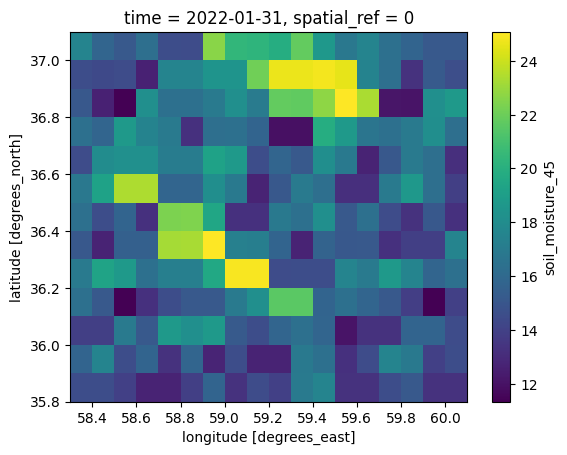

In [68]:
fc = [(i / 100) * 10 * 10 for i in fc_list_10cm]
pwp = [(i / 100) * 10 * 10 for i in wp_list_10cm]



def evap_layer(
    soil_evap_previous,
    inf,
    evap,
    inf_evap_to_transp,
    upward_transp_to_evap,
    fc,
    pwp):
  
  soil_evap = soil_evap_previous + inf + upward_transp_to_evap - evap - inf_evap_to_transp

  if soil_evap <= pwp:
    soil_evap = pwp
    evap = soil_evap_previous - pwp
  elif soil_evap >= fc:
    inf_evap_to_transp = soil_evap - fc
    soil_evap = fc
  
  return soil_evap, evap, inf_evap_to_transp


soil_moisture_45 = np.array([evap_layer(
    soil_evap_previous = float(z),
    inf = float(j),
    evap = float(i),
    inf_evap_to_transp = 0,
    upward_transp_to_evap = 0,
    fc = fc,
    pwp = wp
)[0]
for i, j, z, fc, wp in zip(Ea_pyet, underground_runoff, soil, fc, pwp)])



evap_45 = np.array([evap_layer(
    soil_evap_previous = float(z),
    inf = float(j),
    evap = float(i),
    inf_evap_to_transp = 0,
    upward_transp_to_evap = 0,
    fc = fc,
    pwp = wp
)[1]
for i, j, z, fc, wp in zip(Ea_pyet, underground_runoff, soil, fc, pwp)])


inf_evap_to_transp_45 = np.array([evap_layer(
    soil_evap_previous = float(z),
    inf = float(j),
    evap = float(i),
    inf_evap_to_transp = 0,
    upward_transp_to_evap = 0,
    fc = fc,
    pwp = wp
)[2]
for i, j, z, fc, wp in zip(Ea_pyet, underground_runoff, soil, fc, pwp)])

soil_moisture_45 = soil_moisture_45.reshape(1,number_of_y,number_of_x)


ds1_array_45 = ds1_array_12.assign(soil_moisture_45=(['time', 'y', 'x'], soil_moisture_45))


ds1_array_45.soil_moisture_45.plot()



# simpled transp layer for covered